## Imports

In [1]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

In [2]:
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, Dataset, concatenate_datasets
import transformers
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix


from transformers import AutoTokenizer, DataCollatorWithPadding,BertForSequenceClassification,TrainingArguments,Trainer

from src.utils.myutils import *
import yaml
from tqdm import tqdm
import logging
import json
import warnings
import random
import pandas as pd
from newspaper import Article
from nltk import sent_tokenize
import seaborn as sns

logging.disable(logging.ERROR)
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning) 

CS_DATA_PATH = PATH + '/data/CS/processed/'
CONFIG_PATH = PATH + '/src/utils/config.yaml'
FINAL_PATH = '/home/horyctom/bias-detection-thesis/src/models/trained/final_classifier.pth'


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained("horychtom/czech_media_bias_classifier")

BATCH_SIZE = 32

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


## Function definitions

In [31]:
def classify_sentence(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).argmax(dim=1)
    
    return classification[0].item()

In [32]:
def classify_sentence_bias_prob(sent:str):
    toksentence = tokenizer(sent,truncation=True,return_tensors="pt",max_length=128)
    model.eval()
    model.to(device)
    with torch.no_grad():
        toksentence.to(device)
        output = model(**toksentence)
    
    classification = F.softmax(output.logits,dim=1).squeeze(dim=0)
    
    return classification[1]

In [33]:
def classify_article(url:str):
    article = Article(url)
    article.download()
    article.parse()
    sentences = sent_tokenize(article.text)
    annotations = np.array(list(zip(sentences,list(map(classify_sentence,sentences)))))
    probabilities = np.array(list(zip(sentences,list(map(classify_sentence_bias_prob,sentences)))))
    return annotations,probabilities

In [34]:
def strip_domains(data):
    get_domain = lambda x : '.'.join(x.split('.')[-2:])
    get_section = lambda x : x.split('.')[0] if '.' in x else x
    data['subdomain'] = data['subdomain'].apply(get_domain)
    data['section'] = data['section'].apply(get_section)
    
    return data

In [35]:
def date_format(data):
    data['published'] = data['published'].apply(lambda x: x[:7])
    data = data.assign(Year = data['published'].apply(lambda x: int(x[:4])))
    
    return data

In [37]:
def assign_bias_ratio(data,split:str):
    size = len(data)
    values = np.zeros(size)
    
    for i in tqdm(range(size)):
        text = data.iloc[i][split]
        sentences = sent_tokenize(text)
        labels = np.array(list(map(classify_sentence,sentences)))
        values[i] = 100*np.sum(labels)/len(labels)
    
    data.insert(0,split+'_bias',values)
    
    return data

In [38]:
def assign_bias_headline(data):
    size = len(data)
    values = np.zeros(size)
    
    for i in tqdm(range(size)):
        text = data.iloc[i]['headline']
        values[i] = classify_sentence_bias_prob(text)
        
    data.insert(0,'headline_bias',values)
    
    return data

## Load and clean data

In [184]:
test = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-test.jsonl',lines=True)
dev = pd.read_json('/mnt/data/factcheck/summarization/sumeczech/sumeczech-1.0-dev.jsonl',lines=True)
data = pd.concat([test,dev])

#throaway blogs
data = data[~data['subdomain'].str.contains('blog')]

In [187]:
data.drop(['filename', 'dataset','md5','offset'], axis=1, inplace=True)

In [ ]:
data = data[data['published']!='']
data = date_format(data)
data = strip_domains(data)

In [192]:
denik = data[data.subdomain == 'denik.cz']
ctk = data[data.subdomain == 'ceskenoviny.cz']
idnes = data[data.subdomain == 'idnes.cz']
lidovky = data[data.subdomain == 'lidovky.cz']
novinky = data[data.subdomain == 'novinky.cz']

## Idnes.cz experiments

In [210]:
idnes = assign_bias_ratio(idnes,'abstract')
idnes = assign_bias_headline(idnes)

100%|██████████| 39081/39081 [08:46<00:00, 74.19it/s]


In [211]:
idnes.to_csv('./indes_data.csv',index=False)

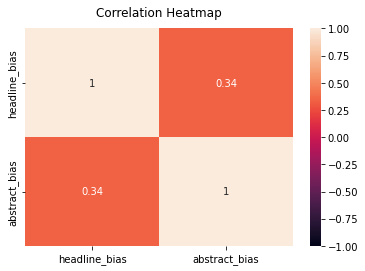

In [212]:
df = idnes[['headline_bias','abstract_bias']]
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

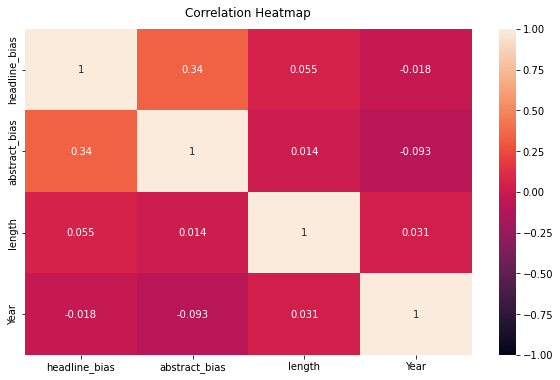

In [213]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(idnes.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [217]:
df = idnes.groupby('published',as_index=False).agg({'headline_bias':'mean'})
df.corr()

,headline_bias
headline_bias,1.0


In [225]:
df = idnes.groupby('section',as_index=False).agg({'headline_bias':'mean'})

In [226]:
df.sort_values(by='headline_bias')

,section,headline_bias
37,z-radnic-a-obci,0.007430
19,oh,0.045119
14,kraje,0.050670
6,cestiny,0.088057
35,wiki,0.090523
25,plzen,0.100826
38,zlin,0.103501
33,vary,0.110620
20,olomouc,0.113115
4,budejovice,0.115013


## Denik.cz experiments

#### interesting properties 
    - length
    - bias of headline, abstract, text
    - section
    - subdomain
    - time

In [193]:
denik = assign_bias_ratio(denik,'abstract')
denik = assign_bias_headline(denik)

100%|██████████| 14413/14413 [03:17<00:00, 72.87it/s]


In [228]:
denik = assign_bias_ratio(denik,'text')

100%|██████████| 14413/14413 [1:25:23<00:00,  2.81it/s]  


In [ ]:
denik['published'] = pd.to_datetime(denik['published'], format = '%Y-%m')

In [231]:
denik.to_csv('./denik_data.csv',index=False)

In [345]:
denik = denik[denik['section'] != 'komentare']

In [346]:
denik = denik[denik['section'] != 'fejeton']

### Correlation between different sections

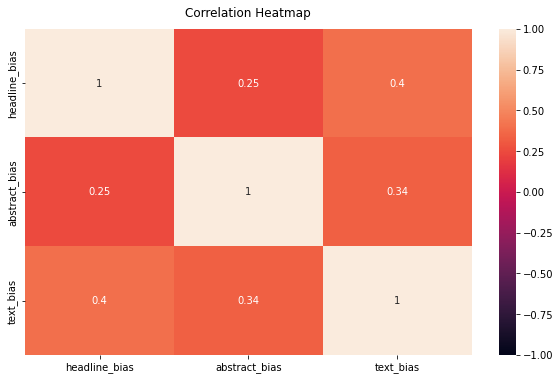

In [367]:
df = denik[['headline_bias','abstract_bias','text_bias']]
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

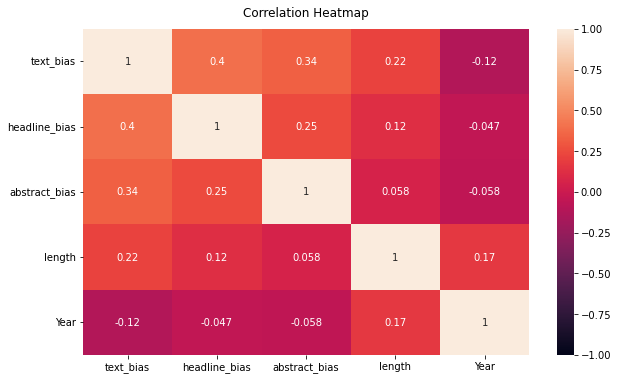

In [368]:
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(denik.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [391]:
df_years = denik.groupby('Year',as_index=False).agg({'text_bias':'mean'})
df_months = denik.groupby('published',as_index=False).agg({'text_bias':'mean'})

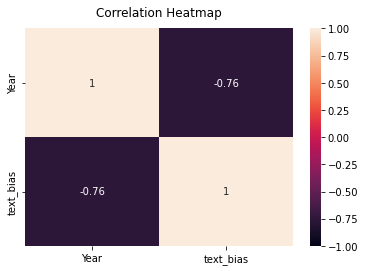

In [371]:
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df_years.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [372]:
df_years

,Year,text_bias
0,2007,0.108502
1,2008,0.119969
2,2009,0.120925
3,2010,0.085044
4,2011,0.070475
5,2012,0.076541
6,2013,0.076334
7,2014,0.071083
8,2015,0.071454
9,2016,0.071549


Text(0.5, 1.0, 'Medi Bias development over years')

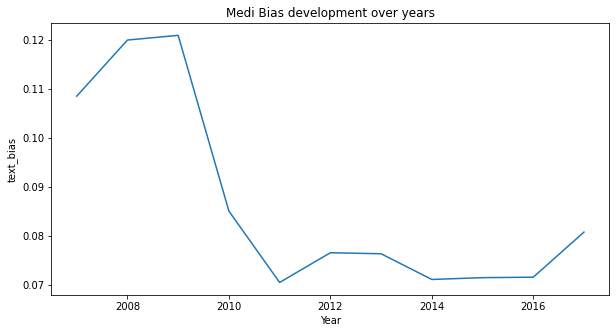

In [373]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='Year', y='text_bias', data=df_years).set_title('Medi Bias development over years')

Text(0.5, 1.0, 'Media Bias development over months')

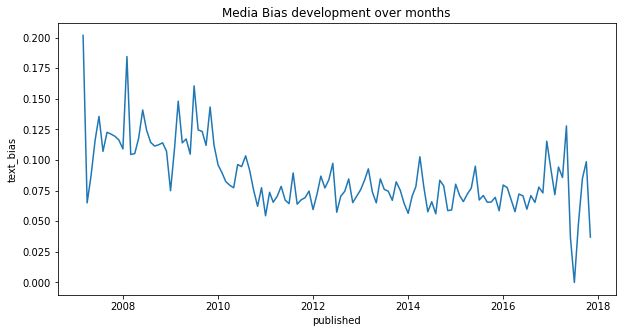

In [394]:
fig, ax = plt.subplots(figsize = (10, 5))
sns.lineplot(ax = ax, x='published', y='text_bias', data=df_months).set_title('Media Bias development over months')

## Bias across different topics

In [375]:
df_sections = denik.groupby('section',as_index=False).agg({'text_bias':'mean'})

In [377]:
df_sections.sort_values(by='text_bias')

,section,text_bias
20,radar,0.000000
8,ekonomika,0.028877
24,reklama,0.031250
35,vzdelavani,0.040000
28,special,0.041667
2,bydleni,0.047952
17,krimi,0.048424
36,zdravi,0.049762
1,auto,0.053181
15,klasa,0.062500


### Volby bias

In [86]:
data = pd.read_csv('denik_data_w_commentary.csv')
data = data[data['section']!='komentare']
data = data[data['section']!='fejeton']

In [87]:
data['headline_bias'] = data['headline_bias'].apply(lambda x: 1 if x >= 0.5 else 0)

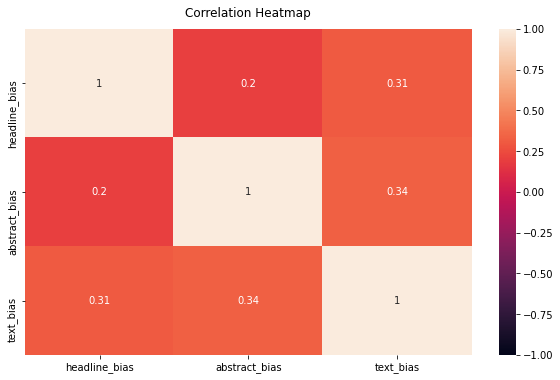

In [88]:
df = data[['headline_bias','abstract_bias','text_bias']]
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [89]:
from scipy.stats import pearsonr

In [93]:
df_years

,Year,text_bias
0,2007,10.850161
1,2008,11.996914
2,2009,12.092549
3,2010,8.504399
4,2011,7.047523
5,2012,7.654079
6,2013,7.633447
7,2014,7.108341
8,2015,7.145373
9,2016,7.154864


In [107]:
pearsonr(data['text_bias'],data['length'])

(0.21768718130678483, 4.680135644248319e-154)

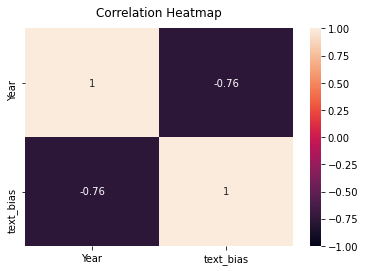

In [98]:
df_years = data.groupby('Year',as_index=False).agg({'text_bias':'mean'})
df_months = data.groupby('published',as_index=False).agg({'text_bias':'mean'})
plt.figure(figsize=(6, 4))
heatmap = sns.heatmap(df_years.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

In [65]:
searchfor = ['volby', 'volební','volbách','voleb']
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,7.959036
True,11.318319


In [66]:
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'median'})

,text_bias
text,
False,4.347826
True,7.692308


In [69]:
searchfor = ['Babiš', 'Babišovi','Babišovo','Babišem','Babišův']
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,8.141556
True,12.936312


In [61]:
classify_article(data.sort_values(by='text_bias').iloc[-100]['url'])[0]

array([['Autoři článků v Pittsburgh Tribune Review by byli jistě nadšeni, že jim ty články někdo žere, ale to netuší, že čtenář Lukáš tak činí doslova.',
        '1'],
       ['Jen jsem se vzdálila na minutku do kuchyně, zvládnul se natáhnout pro sportovní přílohu, a když jsem se vrátila, už ji pěkně zpracovával bezzubými dásněmi.',
        '1'],
       ['Koutky úst mu odkapávala tiskařská čerň a měl zjevně velkou radost nad tím, co píší.',
        '1'],
       ['Tím mě přivedl na myšlenku, že by měl někdo zakódovat abecedu ve speciálním písmu určeném těmto malým čtenářům.',
        '0']], dtype='<U155')

In [69]:
searchfor = ['volby', 'volební','volbách','voleb']
data.groupby(data['text'].str.contains('|'.join(searchfor))).agg({'text_bias':'mean'})

,text_bias
text,
False,7.959036
True,11.318319


In [72]:
data_volby = data[data['text'].str.contains('|'.join(searchfor))].sort_values(by='text_bias')

In [75]:
data_volby

,text_bias,headline_bias,abstract_bias,abstract,headline,length,published,section,subdomain,text,url,Year
4858,0.000000,0.034268,25.0,Svoz odpadu je příliš drahý. Chodníky v zimě n...,Stížnosti na radnicích? I na nehlídanou volebn...,20462,2013-02,denik,denik.cz,Například ve Slavkově u Brna loni dorazilo na ...,http://www.denik.cz/jihomoravsky-kraj/stiznost...,2013
3806,0.000000,0.002142,0.0,Srbské prezidentské volby dnes podle zpřesněný...,Prezidentské volby v Srbsku vyhrál nacionalist...,19431,2012-05,denik,denik.cz,Ve druhém kole voleb zatím poráží původně favo...,https://www.denik.cz/ze_sveta/v-srbskych-prezi...,2012
3757,0.000000,0.009041,0.0,Zástupci pražské TOP 09 předali ČSSD na dnešní...,Pražská TOP 09 předala ČSSD dokument 500 dní p...,19797,2013-06,praha,denik.cz,"""Toto není klasická koaliční smlouva, je to do...",https://www.denik.cz/praha/prazska-top-09-pred...,2013
2061,0.000000,0.004569,0.0,"V pondělí bude jasné, zda se pražská TOP 09 a ...",O nové pražské koalici bude jasno v pondělí,19745,2013-06,praha,denik.cz,ČSSD podle Vávry slevila z požadavku účasti vš...,https://www.denik.cz/praha/sef-klubu-top-09-o-...,2013
3701,0.000000,0.007472,0.0,Senátorkou v obvodě v Praze 10 bude buď místos...,Senátorkou v Praze 10 bude Cabrnochová (SZ) ne...,20083,2014-09,denik,denik.cz,"Doplňovacích voleb se zúčastnilo 15,8 procenta...",http://www.denik.cz/z_domova/senatorkou-v-praz...,2014
...,...,...,...,...,...,...,...,...,...,...,...,...
2976,65.217391,0.615239,50.0,Je to tak trochu zaobalená výzva. Ale všem jas...,Komunisty nebrat! Krajský hejtman Franc čelí v...,20252,2012-11,denik,denik.cz,"Jde o komunisty, samozřejmě. Ti se prosadí do ...",https://www.denik.cz/kralovehradecky-kraj/komu...,2012
14316,66.666667,0.837644,100.0,"""Asi už stárneme, když se náš spolužák z vysok...",Z klávesnice Tomáše Procházky: O cestě Zelenýc...,20604,2016-01,denik,denik.cz,"Na časy ""pravicových zelených"" Martina Bursíka...",https://www.denik.cz/z_domova/z-klavesnice-tom...,2016
9777,66.666667,0.699667,75.0,Kdekdo komentuje dění u našich polských soused...,Z klávesnice Kateřiny Perknerové: Co chtějí Če...,20838,2016-01,denik,denik.cz,Země visegrádské čtyřky jsou vedle Velké Britá...,https://www.denik.cz/z_domova/z-klavesnice-kat...,2016
5636,72.222222,0.255511,50.0,Když se naposledy na Pražském hradě volil pres...,Když nejde o život,18064,2008-02,denik,denik.cz,"Někteří se, pravda, vymlouvali, že šlo o hodně...",https://www.denik.cz/hoffmanuv_denik/kdyz-nejd...,2008


In [219]:
f = classify_article(data_volby.iloc[-21]['url'])[0]
f

array([['„Požádal jsem generálního manažera pana Šaffera, aby nám doručil DVD ztohoto utkání.',
        '0'],
       ['Komise rozhodčích záznam prozkoumá," uvedl Stanislav Šulc.',
        '0'],
       ['Šaffer se dnes již opátečním incidentu nechtělbavit.', '0'],
       ['Rozhodčí René Hradil otomto incidentu nic nenapsal do oficiálního zápisu.',
        '0'],
       ['Přesto podle Šulce záležitost ještě není ukonce.', '0'],
       ['Podle pardubického primátora je ale současné postavení hokejistů Moelleru spíše výjimečné a vPardubicích se vždy více tleskalo než nadávalo.',
        '0'],
       ['„Primátorovi Kubatovi ale rozumím, Ústí je poslední, prodělává krizi a Kubata tomu hokeji podléhá, úplně ho pohltil.',
        '1'],
       ['Je sním tak spjat, že se pak lehce může nechat unést knějakým výstřelkům.',
        '1'],
       ['Myslím si ale, že těch výroků bude litovat.', '1'],
       ['Nicméně je to silná osobnost, a tak to určitě ustojí,“ charakterizuje svého kolegu pardubický 

In [212]:
data_volby.iloc[-18]['url']

'http://www.denik.cz/ze_sveta/rakousko_pristehovalci20080807.html'

In [215]:
f[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [152]:
toksentence = tokenizer('Ahoj.',truncation=True,return_tensors="pt",max_length=128)
model.eval()
model.to(device)
with torch.no_grad():
    toksentence.to(device)
    output = model(**toksentence)

In [154]:
output.logits

tensor([[ 1.3067, -1.0469]])

In [155]:
model.classifier

Linear(in_features=768, out_features=2, bias=True)

In [156]:
import torch

In [166]:
l = torch.nn.Linear(20,2,True)

In [167]:
l._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[-0.0231, -0.1564,  0.1954,  0.0447,  0.1817,  0.1767,  0.1194, -0.0711,
                       -0.1879,  0.0899,  0.0569, -0.2223, -0.1012, -0.0985, -0.0420,  0.0212,
                        0.1865, -0.1197,  0.1630,  0.2170],
                      [-0.1772, -0.2072,  0.0559,  0.1176, -0.0165,  0.1658,  0.1265, -0.1127,
                       -0.1781, -0.2205,  0.1883, -0.1623, -0.0483, -0.1772,  0.1538, -0.0453,
                       -0.1859, -0.1356, -0.0274,  0.1411]], requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([-0.0802, -0.1491], requires_grad=True))])

In [185]:
np.mean(model.classifier._parameters['weight'].detach().numpy())

-0.00028133337

In [189]:
model.classifier._parameters

OrderedDict([('weight',
              Parameter containing:
              tensor([[ 0.0094,  0.0316,  0.0195,  ..., -0.0271,  0.0040, -0.0142],
                      [ 0.0031,  0.0187, -0.0087,  ..., -0.0229, -0.0437,  0.0023]],
                     requires_grad=True)),
             ('bias',
              Parameter containing:
              tensor([ 7.8230e-06, -7.8262e-06], requires_grad=True))])

In [192]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [200]:
list(torch.nn.Dropout.parameters(,torch.nn.Linear(2,3,False)))

[Parameter containing:
 tensor([[ 0.1011, -0.3392],
         [ 0.1094, -0.6805],
         [ 0.2691,  0.5493]], requires_grad=True)]

In [204]:
for param in model.classifier.parameters():
    print(type(param), param.size())

<class 'torch.nn.parameter.Parameter'> torch.Size([2, 768])
<class 'torch.nn.parameter.Parameter'> torch.Size([2])


In [208]:
F.softmax(torch.Tensor([1,2]))

tensor([0.2689, 0.7311])

In [225]:
model2 = RobertaForTokenClassification.from_pretrained('ufal/robeczech-base')

In [229]:
from transformers import AutoModel

In [230]:
tokenizer = AutoTokenizer.from_pretrained("fav-kky/FERNET-News")

model = AutoModel.from_pretrained("fav-kky/FERNET-News")

Downloading:  59%|█████▉    | 295M/501M [18:47:17<13:06:40, 4.36kB/s]


In [235]:
tokenizer = AutoTokenizer.from_pretrained("fav-kky/FERNET-News")
model2 = RobertaForSequenceClassification.from_pretrained("fav-kky/FERNET-News")

In [237]:
model2

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(51961, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm

In [238]:
from transformers import BertForSequenceClassification

In [240]:
model_name = 'fav-kky/FERNET-C5'
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False,padding=True)
model = BertForSequenceClassification.from_pretrained("horychtom/czech_media_bias_classifier")

In [241]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen